# トークトリアル 8

# タンパク質データの取得: Protein Data Bank (PDB)

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Anja Georgi, Majid Vafadar and Dominique Sydow

## このトークトリアルの目的

このトークトリアルでは、次のトークトリアルのための土台を準備します。次のトークトリアルではEGFRに対するリガンドベースの組み合わせファーマコフォア（ligand-based ensemble pharmacophore）を作成します。したがって準備として(i) PDBデータベースからEGFRの全てのPDB IDを取得し、(ii) X線結晶構造解析による構造で、最も質の良い５つのタンパク質ーリガンド複合体構造を取得、そして、(iii) ５つの構造を互いに3Dで重ね合わせ（アラインメント）、次のトークトリアルで使用するためにリガンドを抜き出し保存します。

## 学習の目標

### 理論
* Protein Data Bank (PDB)
* Pythonパッケージ PyPDB
 
### 実践

* 検索するクエリタンパク質の選択
* クエリタンパク質のPDBエントリーに関する統計値を取得
* クエリタンパク質の全PDB IDを取得
* PDBエントリーのメタ情報を取得
* PDBエントリーのメタ情報をフィルタリングし並べ替え
* 上位の構造からリガンドのメタ情報を取得
* 上位リガンド化合物を描画
* タンパク質ーリガンド　IDのペアを作成
* PDB構造ファイルの取得
* PDB構造の重ね合わせ
 
## レファレンス

* Protein Data Bank 
([PDB website](http://www.rcsb.org/pdb>))
* PyPDB pythonパッケージ
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))
* PyPDB pythonパッケージドキュメンテーション
([PyPDB website](http://www.wgilpin.com/pypdb_docs/html/))
* PyMol selection algebra 
([PyMolWiki: selection algebra](https://pymolwiki.org/index.php/Selection_Algebra))

## 理論

### Protein Data Bank (PDB)

Protein Data Bank (PDB) は構造生物学に関する情報のデータベースの中で最も包括的なものの一つで、構造ゲノム科学と医薬品デザインといった構造生物学の分野で重要な情報源です。([PDB Webサイト](http://www.rcsb.org/pdb>))

構造のデータは、X線結晶構造解析（最も良く使われている手法）、核磁気共鳴（NMR）そしてクライオ電子顕微鏡（cryo-EM）といった構造決定手法によって取得されています。各エントリーについて、データベースに含まれている情報には(i) タンパク質、リガンド、補因子、水分子、そしてイオンといった原子と、原子同士をつなぐ結合の３次元座標、そして(ii) PDB ID、著者、登録日、用いられた構造決定手法や構造の分解能といった構造情報に関するメタ情報があります。

構造の分解能（resolution）は、集められたデータの質の指標で、単位はÅ（オングストローム）です。この値が小さいほど、構造の質はより良いものとなります。

PDB　Webサイトはタンパク質の構造（と、手に入る場合はリガンドとの相互作用）の３次元描画と、構造の質の指標（メトリクス）とを提供しています。例として、上皮増殖因子（EGFR）のPDBエントリー  [PDB ID 3UG5](https://www.rcsb.org/structure/3UG5) で見ることができます。

<img src="./images/protein-ligand-complex.png" align="above" alt="Image cannot be shown" width="400">
<div align="center"> Figure 1: 上皮増殖因子（EGFR）の例としてPDB ID 3UG5のタンパク質構造（灰色）と相互作用するリガンド（緑色）を描画（Dominique Sydowによる図）。</div>

### PyPDB

PyPDBはPDBのためのPythonプログラミングインターフェースで、Python3でのみ機能します。
このパッケージを利用することで、バイオインフォマティクスのワークフローにPDB自動検索を組み込み、既存の検索結果に基づいて多数の検索をおこなうプロセスを簡略化することができます。
また、PDBエントリーの情報について高度な検索を行うことも可能になります。PDBは現在RESTful APIを使用しており、標準的なHTMLボキャブラリーを使用して情報を取得することができます。PyPDBはこれらのオブジェクトをXML文字列に変換します。
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))

提供されている機能（関数）のリストはPyPDBドキュメンテーションのWebサイトで見ることができます([PyPDB website](http://www.wgilpin.com/pypdb_docs/html/))。

## 実践

In [3]:
# 必要なライブラリのインポート
from pypdb import *
from pymol import *

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True

import pprint
import glob

import pandas as pd
from array import array
import numpy as np
import collections

import matplotlib.pyplot as plt
%matplotlib inline

RDKit WARNING: [17:08:30] Enabling RDKit 2019.09.3 jupyter extensions


### 検索するクエリタンパク質の選択

このトークトリアルではEGFRをクエリタンパク質として使います。EGFRのUniProt IDは`P00533`で、以降のPDBデータベース検索でこのIDを使います。

### クエリタンパク質のPDBエントリーに関する統計値を取得

まず最初の質問です。「EGFRについて、毎年いくつのエントリーがPDBに登録されていて、全体ではいくつになるのでしょうか？」

 [PDB Webサイト](http://www.rcsb.org/pdb>) で検索ターム「`P00533`」で検索することができます。2018年10月現在、PDBでの検索結果は179でした。
 
**訳注(2020/05)**  
2020年5月現在、検索結果は207でした。    
**訳注ここまで**
 
`pypdb`を使うと、PDBデータベースから全てのEGFR構造の登録日（deposition date）を取得することができます。`find_dates`関数のパラメーター`max_results`を設定するために、登録されている構造の数が必要となります。

In [18]:
#　注: max_results パラメーターのデフォルトは100でEGFRのエントリーに対して少なすぎます。
# max_results > EGFR構造の最大の数 となるとエラーが出ます。
# 従って実行前に結果がいくつあるかチェックしました。(#179) 
# 訳注: 2020年5月時点では207で、以下のコードも合わせて変更しています。207ではStopIterationとなったので205としています。

# このデータベースクエリには時間がかかるかもしれません（数分程度）
# all_dates = find_dates("P00533", max_results=179)  
all_dates = find_dates("P00533", max_results=205)  

In [19]:
print("Number of EGFR structures found: " + str(len(all_dates)))

Number of EGFR structures found: 205


In [20]:
# 登録日の例
all_dates[:3]

['2002-03-28', '2002-06-17', '2002-06-17']

登録日から登録年の情報を抽出し、各年毎の登録数のヒストグラムを計算します。

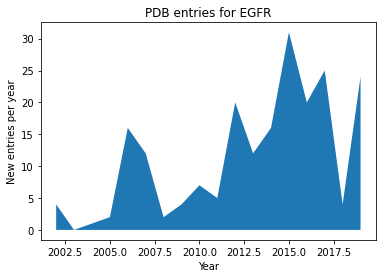

In [21]:
# 登録年の抽出
all_dates = np.asarray(all_dates)
all_years = np.asarray([int(depdate[:4]) for depdate in all_dates])

# ヒストグラムの計算
bins = max(all_years)-min(all_years)  # ビンの数 = 登録年の範囲
subs_v_time = np.histogram(all_years, bins)

# 全エントリー（2018年を除く）のプロット
# 訳注: 最新年を除く設定なので用いたデータにより除かれる年は異なります
dates, num_entries = subs_v_time[1][:-1], subs_v_time[0]  

# ヒストグラムの表示
fig = plt.figure()
ax = plt.subplot(111)
ax.fill_between(dates, 0, num_entries)
ax.set_ylabel("New entries per year")
ax.set_xlabel("Year")
ax.set_title("PDB entries for EGFR")
plt.show()

### クエリタンパク質の全PDB IDを取得

次に、`pypdb`関数の`make_query`と`do_search`を使って、クエリタンパク質EGFRについての全てのPDB構造を取得します。

In [22]:
search_dict = make_query("P00533")  #  max_resultsが180以上の場合タイムアウトになる可能性があります。
found_pdb_ids = do_search(search_dict)

print("PDB IDs found for query: ")
print(found_pdb_ids)

print("\nNumber of structures: " + str(len(found_pdb_ids)))

PDB IDs found for query: 
['1IVO', '1M14', '1M17', '1MOX', '1XKK', '1YY9', '1Z9I', '2EB2', '2EB3', '2GS2', '2GS7', '2ITN', '2ITO', '2ITP', '2ITQ', '2ITT', '2ITU', '2ITV', '2ITW', '2ITX', '2ITY', '2ITZ', '2J5E', '2J5F', '2J6M', '2JIT', '2JIU', '2JIV', '2KS1', '2M0B', '2M20', '2N5S', '2RF9', '2RFD', '2RFE', '2RGP', '3B2U', '3B2V', '3BEL', '3BUO', '3C09', '3GOP', '3GT8', '3IKA', '3LZB', '3NJP', '3OB2', '3OP0', '3P0Y', '3PFV', '3POZ', '3QWQ', '3UG1', '3UG2', '3VJN', '3VJO', '3VRP', '3VRR', '3W2O', '3W2P', '3W2Q', '3W2R', '3W2S', '3W32', '3W33', '4G5J', '4G5P', '4HJO', '4I1Z', '4I20', '4I21', '4I22', '4I23', '4I24', '4JQ7', '4JQ8', '4JR3', '4JRV', '4KRL', '4KRM', '4KRO', '4KRP', '4LI5', '4LL0', '4LQM', '4LRM', '4R3P', '4R3R', '4R5S', '4RIW', '4RIX', '4RIY', '4RJ4', '4RJ5', '4RJ6', '4RJ7', '4RJ8', '4TKS', '4UIP', '4UV7', '4WD5', '4WKQ', '4WRG', '4ZAU', '4ZJV', '4ZSE', '5C8K', '5C8M', '5C8N', '5CAL', '5CAN', '5CAO', '5CAP', '5CAQ', '5CAS', '5CAU', '5CAV', '5CNN', '5CNO', '5CZH', '5CZI', '5D41

**訳注(05/2020)**  
RCSB PDBのWebページで「P00533」を検索するとヒットしたエントリーは207でしたが、ここでは205個のエントリーがヒットしています。「2.5.2節：クエリタンパク質のPDBエントリーに関する統計値を取得」において`max_results=207`とすると途中でとまってしまいましたが、`205`では実行可能でした。タイムアウトが原因か、もしくはデータベースの問題かはわかりませんでした。  
**訳注ここまで**

### PDBエントリーのメタ情報を取得

`describe_pdb`を使って構造のメタ情報を取得します。メタ情報は構造毎に辞書として格納されます。

注：ここではPDB構造のメタ情報を取得するだけで、構造そのもの（３次元座標）はまだ取得しません。

In [23]:
# このデータベースクエリには少し時間がかかるかもしれません。
pdbs = []
for i in found_pdb_ids:
  pdbs.append(describe_pdb(i))

pdbs[0]

{'relatedPDB': {'@pdbId': '1JL9',
  '@details': '1JL9 contains dymeric human EGF molecules.'},
 'structureId': '1IVO',
 'title': 'Crystal Structure of the Complex of Human Epidermal Growth Factor and Receptor Extracellular Domains.',
 'pubmedId': '12297050',
 'expMethod': 'X-RAY DIFFRACTION',
 'resolution': '3.30',
 'keywords': 'TRANSFERASE/SIGNALING PROTEIN',
 'nr_entities': '2',
 'nr_residues': '1350',
 'nr_atoms': '8813',
 'deposition_date': '2002-03-28',
 'release_date': '2002-10-16',
 'last_modification_date': '2011-07-13',
 'structure_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Shirouzu, M., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)',
 'citation_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Inoue, M., Shirouzu, M., Yokoyama, S.',
 'status': 'CURRENT'}

### PDBエントリーのメタ情報をフィルタリングし並べ替え

取得した情報を関連するPDB構造をフィルタリングして絞り込むために使いたいので、データセットを辞書からより扱いやすいデータフレームに変換します。

In [24]:
pdbs = pd.DataFrame(pdbs)
pdbs.head()

,relatedPDB,structureId,title,pubmedId,expMethod,resolution,keywords,nr_entities,nr_residues,nr_atoms,deposition_date,release_date,last_modification_date,structure_authors,citation_authors,status,pubmedCentralId
0,"{'@pdbId': '1JL9', '@details': '1JL9 contains ...",1IVO,Crystal Structure of the Complex of Human Epid...,12297050,X-RAY DIFFRACTION,3.30,TRANSFERASE/SIGNALING PROTEIN,2,1350,8813,2002-03-28,2002-10-16,2011-07-13,"Ogiso, H., Ishitani, R., Nureki, O., Fukai, S....","Ogiso, H., Ishitani, R., Nureki, O., Fukai, S....",CURRENT,NaN
1,"{'@pdbId': '1M17', '@details': 'Epidermal Grow...",1M14,Tyrosine Kinase Domain from Epidermal Growth F...,12196540,X-RAY DIFFRACTION,2.60,TRANSFERASE,1,333,2452,2002-06-17,2002-09-04,2011-07-13,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.","Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",CURRENT,NaN
2,"{'@pdbId': '1M14', '@details': 'Apo-form Epide...",1M17,Epidermal Growth Factor Receptor tyrosine kina...,12196540,X-RAY DIFFRACTION,2.60,TRANSFERASE,1,333,2540,2002-06-17,2002-09-04,2011-07-13,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.","Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",CURRENT,NaN
3,"[{'@pdbId': '1IGR', '@details': '1IGR contains...",1MOX,Crystal Structure of Human Epidermal Growth Fa...,12297049,X-RAY DIFFRACTION,2.50,transferase/growth factor,2,1102,8607,2002-09-10,2003-09-10,2011-07-13,"Garrett, T.P.J., McKern, N.M., Lou, M., Ellema...","Garrett, T.P.J., McKern, N.M., Lou, M., Ellema...",CURRENT,NaN
4,NaN,1XKK,EGFR kinase domain complexed with a quinazolin...,15374980,X-RAY DIFFRACTION,2.40,TRANSFERASE,1,352,2299,2004-09-29,2004-12-07,2011-07-13,"Wood, E.R., Truesdale, A.T., McDonald, O.B., Y...","Wood, E.R., Truesdale, A.T., McDonald, O.B., Y...",CURRENT,NaN


In [25]:
print("Number of PDB structures for EGFR: " + str(len(pdbs)))

Number of PDB structures for EGFR: 205


データセットを以下のクライテリアに沿ってフィルタリングしていきます。

#### 1. 実験手法：X線回折（X-ray diffraction）

X線回折（`X-RAY DIFFRACTION`）によって解かれた構造のみを残します。X線回折は最もよく使われている構造決定手法です。

In [26]:
pdbs = pdbs[pdbs.expMethod =="X-RAY DIFFRACTION"]
print("Number of PDB structures for EGFR from X-ray: " + str(len(pdbs)))

Number of PDB structures for EGFR from X-ray: 199


#### 2. 構造分解能

分解能が3Å（Angström）以下の構造のみを残します。分解能の値が小さいほど、構造の質が良くなります（＝質が良いとは、原子に割り当てられた３次元座標の確からしさが高くなるということです）。3Åよりも下の場合、原子レベルの配置を決めることができ、したがって構造に基づく医薬品デザイン（structure-based drug design）に関連する構造を選択するための閾値として使われることがよくあります。

In [27]:
pdbs_resolution = [float(i) for i in pdbs.resolution.tolist()]
pdbs = pdbs[[i <= 3.0 for i in pdbs_resolution]]

print("Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: " + str(len(pdbs)))

Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: 164


データセットを構造の分解能で並べ替えます。

In [28]:
pdbs = pdbs.sort_values(["resolution"], 
                        ascending=True, 
                        na_position='last')

（分解能でソートした）上位のPDB構造を確認します。

In [29]:
pdbs.head()[["structureId", "resolution"]]

,structureId,resolution
153,5UG9,1.33
141,5HG8,1.42
152,5UG8,1.46
50,3POZ,1.50
56,3VRP,1.52


#### 3. リガンドの結合した構造

次のトークトリアルでリガンドベースの組み合わせファーマコフォア（ensemble ligand-based pharmacophore）を作成するので、データフレームから結合するリガンドを含まないPDB構造を取り除きます。`pypdb`関数の`get_ligands`を使うことでPDB構造に含まれるリガンドの確認と取得ができます。PDBでリガンドと分類されているものにはリガンド、補因子だけでなく溶媒とイオンも含まれています。リガンドの結合した構造だけに絞り込むため、(i) リガンドに分類されている物を含まないすべての構造を取り除き、そして(ii) 分子量（MW）100Da（ダルトン）以上のリガンドを含まない構造をすべて取り除きます。分子量100Daとするのは多くの溶媒とイオンの分子量がそれよりも小さいからです。注：この方法は簡単ですが、全ての溶媒とイオンを除去する方法ではありません。

In [30]:
# データフレームからPDB IDを取得
# pdb_ids = pdbs["structureId"].get_values().tolist() 
# 訳注: オリジナル資料の上記コードはpandas version 0.25.0以降では使用できなくなっています。
pdb_ids = pdbs["structureId"].to_numpy().tolist() 

In [31]:
# 構造の除去
# (i) リガンドを持たないもの
# (ii) 分子量(MW)が100 Da(Dalton)以上のリガンドを持たないもの

mw_cutoff = 100.0  # 分子量のカットオフ値（単位Da）

# このデータベースクエリはしばらく時間がかかるかもしれません
removed_pdb_ids = []
for i in pdb_ids:
    ligand_dict = get_ligands(i)
    
    # (i) リガンドがない場合に構造を取り除く
    if ligand_dict["ligandInfo"] is None:
        pdb_ids.remove(i) # リストからリガンドのないPDB IDを取り除く
        removed_pdb_ids.append(i) # リガンドのないPDB IDを格納
    
    # (ii) mw_cutoff以上の分子量のリガンドを一つも持たない構造の除去
    else:
        # リガンド情報の取得
        ligs = ligand_dict["ligandInfo"]["ligand"]
        # 専門的な事項：リガンドが一つの時、辞書型からリスト型へキャストします（続けてリスト内包表記処理するため）
        if type(ligs) == dict:
            ligs = [ligs]
        # リガンドと分類されているもの毎に分子量を取得
        mw_list = [float(i["@molecularWeight"]) for i in ligs]
        # 分子量（MW）100Da（ダルトン）以上のリガンドを含まない構造を除去
        if sum([mw > mw_cutoff for mw in mw_list]) == 0:
            pdb_ids.remove(i) # リストからリガンドのないPDB IDを取り除く
            removed_pdb_ids.append(i) # リガンドのないPDB IDを格納

print("PDB structures without a ligand (removed from our data set):")
print(removed_pdb_ids)

PDB structures without a ligand (removed from our data set):
['2EB2', '1M14', '2GS2', '2RFE', '4I1Z']


In [32]:
print("Number of structures with ligand: " + str(len(pdb_ids)))

Number of structures with ligand: 159


### 上位の構造からリガンドのメタ情報を取得

次のトークトリアルでは、最も分解能の高い上位の`top_num`構造からリガンドベースの組み合わせファーマコフォアを作成します。

In [33]:
top_num = 4  # 上位の構造の数
pdb_ids = pdb_ids[0:top_num]
pdb_ids

['5UG9', '5HG8', '5UG8', '3POZ']

`get_ligands`を使って上位`top_num`個のリガンドについてPDB情報を取得し、*csv* ファイルとして保存します（リガンド毎の辞書）。

構造が複数のリガンドを含んでいる場合、最も大きなリガンドを選びます。注：これは単純な方法で、タンパク質の結合サイトに結合するリガンドを選択するうえで完璧な方法ではありません。このアプローチではタンパク質に結合する補因子を選んでしまう可能性もあります。ですので、以降のステップで使用する前に、PyMolで自動的に選択した上位のリガンドをチェックしてください。

In [34]:
ligands_list = []

for i in pdb_ids:
    ligands = get_ligands(i)["ligandInfo"]["ligand"]
    # 専門的な事項：リガンドが一つの時、辞書型からリスト型へキャストします（続けてリスト内包表記処理するため）
    if type(ligands) == dict:
        ligands = [ligands]

    weight = 0
    this_lig = {}
    
    # 幾つかリガンドが含まれている場合、最大のものを取得
    for lig in ligands:
        if float(lig["@molecularWeight"]) > weight:
            this_lig = lig
            weight = float(lig["@molecularWeight"])
            
    ligands_list.append(this_lig)

# フォーマットをデータフレームに変更
ligs = pd.DataFrame(ligands_list)
ligs

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,non-polymer,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,non-polymer,377.4,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,non-polymer,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,3POZ,03P,non-polymer,547.957,N-{2-[4-({3-chloro-4-[3-(trifluoromethyl)pheno...,C26 H25 Cl F3 N5 O3,"InChI=1S/C26H25ClF3N5O3/c1-25(2,37)14-22(36)31...",ZYQXEVJIFYIBHZ-UHFFFAOYSA-N,CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)O...


In [35]:
ligs.to_csv('../data/T8/PDB_top_ligands.csv', header=True, index=False, sep='\t')

### 上位リガンド分子の描画

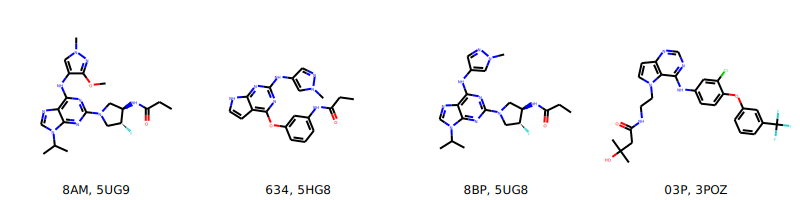

In [36]:
PandasTools.AddMoleculeColumnToFrame(ligs, 'smiles')
Draw.MolsToGridImage(mols=list(ligs.ROMol), 
                     legends=list(ligs['@chemicalID']+', '+ligs['@structureId']), 
                     molsPerRow=top_num)

### タンパク質ーリガンド IDペアの作成

In [38]:
pairs = collections.OrderedDict()

for idx, row in ligs.iterrows():
    pairs[str(row['@structureId'])] = str(row['@chemicalID'])

print(pairs)

OrderedDict([('5UG9', '8AM'), ('5HG8', '634'), ('5UG8', '8BP'), ('3POZ', '03P')])


**訳注(2020/05)**  
OrderedDictは順序つきの辞書です。ここではタンパク質のPDB IDとリガンドのIDをそれぞれDataFrameの`@structureId`列と`@chemicalID`列から取得し、keyとvalueとしています。  
**訳注ここまで**

### PDB構造ファイルの取得

では、`pypdb`の`get_pdb_file`関数を使ってPDBからPDB構造ファイルを取得します。すなわちタンパク質、リガンド（そして可能な場合には補因子や水分子、そしてイオンといった他の原子あるいは分子）の３次元座標を取得します。
利用可能なファイルフォーマットは*pdb*と*cif*で、タンパク質（とリガンド、補因子、水分子、イオン）の原子の３次元座標と、原子間の結合に関する情報とが格納されています。ここでは*pdb*ファイルを使用します。

In [39]:
# PDBファイルを取ってきてローカルに保存する
for prot, lig in pairs.items():
    pdb_file = get_pdb_file(prot, filetype='pdb', compression=False)
    with open('../data/T8/'+ prot + '.pdb', 'w') as f:
        f.write(pdb_file)

### PDB構造の重ね合わせ

次のトークトリアルでリガンドベースの組み合わせファーマコフォアを作成したいので、全ての構造を互いに３次元で重ね合わせする（アラインメントを取る）必要があります。このタスクのため、分子描画プログラムPyMolを使用します。PyMolはJupyter notebookの中でも使うことができます。PyMolは２つの構造間の原子の距離が最小になるように、一度に２つの構造の重ね合わせをします。

まず最初にコマンドラインからPyMolを立ち上げます（quietモード、すなわちGUIが開かないモード）。

In [40]:
# PyMolをquietモードで立ち上げる
pymol.pymol_argv = ['pymol','-qc']
pymol.finish_launching()

重ね合わせのために、リファレンスとなる構造のファイル（動かさないPDB、'target'）を選択し、それに対してもう一方の（'query'）構造ファイルを、PyMolのコマンド`cmd.align(query, target)`を使って重ね合わせます。全ての `cmd.` コマンドはPyMolのコマンドです。

重ね合わせた構造を新しい座標とともに*pdb* ファイルとして保存します。また、構造ファイルからリガンドを取り出して別の*pdb*ファイルとして保存し、次のトークトリアルで使用します。

In [41]:
# アラインメントのログをファイルに保存
f = open("../data/T8/alignments.log", "w")

# アラインメントの間、動かさない構造と動かす構造とを区別するための変数
immobile_pdb = True
refAlignTarget='non'
refAlignQuery='non'

# 最初のタンパク質に対してタンパク質のアラインメントを取る
for prot, lig in pairs.items():
    
    # 動かさない構造（アラインメントのリファレンス構造）
    if immobile_pdb:
        target = prot
        f.write('Immobile target: ' + prot + '\n')
        
        # pdbファイルの読み込み（タンパク質とリガンドの複合体）
        targetFile = cmd.load('../data/T8/' + target + '.pdb')
        # 精密化したアラインメントのための名前を格納
        refAlignTarget='('+target+' within 5 of resn '+lig+')'
        
        # 複合体をpdbファイルとして保存
        cmd.save('../data/T8/' + target + '_algn.pdb', selection=target)
        
        # 選択した名前のリガンドだけを選択
        ligObj = cmd.select('ligand', target + ' and resn ' + lig)
        # 選択したものをpdbファイルとして保存
        cmd.save('../data/T8/' + target + '_lig.pdb', selection='ligand', format='pdb')
        # リガンドの選択を削除
        cmd.delete(ligObj)
        # targetが選択されました。
        immobile_pdb = False
        
    # 動かす構造（リファレンス構造に対して重ね合わせる）
    else:
        query = prot
        f.write('-- align %s to %s \n' %(query, target))
        
        # pdbファイルの読み込み（タンパク質のリガンドの複合体）
        queryFile = cmd.load('../data/T8/' + query + '.pdb')
        
        # 結合サイトに焦点をあてて構造（タンパク質）を重ね合わせる
        refAlignQuery= '('+query+' within 5 of resn '+lig+')' 
        values = cmd.align(refAlignQuery, refAlignTarget)
        
        
        # 構造の重ね合わせができない場合（即ち、RMSD > 5A の場合）、スキップする
        if values[0] > 5:
            f.write('--- bad alignment: skip structure\n')
        else:
            # 複合体をpdbファイルとして保存
            cmd.save('../data/T8/' + query + '_algn.pdb', selection=query)
            
            # リガンドのみを選択
            ligObj = cmd.select('ligand', query + ' and resn ' + lig)
            
            # 選択したものをpdbファイルとして保存
            cmd.save('../data/T8/' + query + '_lig.pdb', selection='ligand', format='pdb')
            
            # リガンドの選択を削除
            cmd.delete(ligObj)
            
        # "query"の選択を削除
        cmd.delete(query)
    
# "target"の選択を削除
cmd.delete(target)

f.close()

**訳注(2020/05)**  
Pymol Wikiを参照して上のセルの補足をします。  
アラインメントのコマンド`cmd.align`に渡す引数の`refAlignTarget`と`refAlignQuery`はどちらも`( PDB_ID within 5 resn of Ligand_ID)`という文字列になる変数です。これは「タンパク質（PDB_ID）のうち、残基名(resn, residune name)で指定されたリガンド（Ligand_ID）の5Å以内に入る部分」を指し示すようです。リガンドの周囲を指定してアラインメントをとっているので「結合サイトに焦点をあてて重ね合わせる」ことになるようです。  
また、`cmd.align`の戻り値は7つあり、一番最初（index 0）が「精密化した後のRMSD」となっているため、`if values[0] > 5`という条件文になっているようです（[PyMol Wiki: Align](https://pymolwiki.org/index.php/Align)）。  
**訳注ここまで**

PyMolアプリケーションを終了します。

In [42]:
# PyMolを終了
pymol.cmd.quit()

全てのリガンド*pdb*ファイルが存在していることを確認します。もしファイルが欠けていたなら、手作業でPyMOLでタンパク質ーリガンド複合体構造をチェックしてください。

In [43]:
mol_files = []
for file in glob.glob("../data/T8/*_lig.pdb"):
    mol_files.append(file)
mol_files

['../data/T8/5UG8_lig.pdb',
 '../data/T8/3POZ_lig.pdb',
 '../data/T8/5UG9_lig.pdb',
 '../data/T8/5HG8_lig.pdb']

## ディスカッション

このトークトリアルでは、PDBからタンパク質とリガンドのメタ情報と構造情報を取得する方法を学びました。X線構造だけを残し、分解能とリガンドがあるかどうかによって絞りこみました。最終的な目標は、重ね合わせたリガンドのセットを使って、次のトークトリアルでリガンドベースの組み合わせファーマコフォアを作成することです。

ファーマコフォアモデリングのためにリガンドについての情報量を多くするため、PDB構造を分解能でフィルタリングするだけでなく、リガンドの多様性をチェックすること（類似性による分子クラスタリングについては**トークトリアル 5**を参照）と、リガンドの生理活性をチェックする（即ち、活性があるリガンドだけを含める）ことをお勧めします。

## クイズ

1. Protein Data Bankの含むデータの種類を要約してください。
2. 構造の分解能が何を表し、このトークトリアルではどうやって、また、なぜ分解能についてフィルタリングしたのかを説明してください。
3. 構造の重ね合わせ（アラインメントを取ること）とはどういう意味か説明し、このトークとリアルで実施したアラインメントについて議論してください。